![스크린샷, 2023-10-04 10-29-45.png](<attachment:스크린샷, 2023-10-04 10-29-45.png>)

$x(t)$ : item feature vector

$W(t) = W$ : constant

$y(t)$ : mood feature vector (음악을 듣기 전 감정)

Linear case로 변환

$(vec(x_{u_t}y_a^T))^T vec(W)$
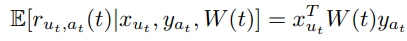

In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
class MAB(ABC):
    
    @abstractmethod
    def play(self, tround, context):
        # Current round of t (for my implementations average mean reward array 
        # at round t is passed to this function instead of tround itself)
        self.tround = tround
        # Context: features of contextual bandits
        self.context = context
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(self.tround==max(self.tround))[0])
        return chosen_arm
        pass
        
    
    @abstractmethod
    def update(self, arm, reward, context):
        # get the chosen arm
        self.arm = arm
        # get the context (may be None)
        self.context = context
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[self.arm] += 1
        # update average mean reward of each arm
        self.AM_reward[self.arm] = ((self.step_arm[self.arm] - 1) / float(self.step_arm[self.arm]) 
        * self.AM_reward[self.arm] + (1 / float(self.step_arm[self.arm])) * reward)
        return
        pass

In [3]:
class EpsGreedy(MAB):
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Exploration probability
        self.epsilon = epsilon
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return
        
    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Generate random number
        p = np.random.rand()
        
        if self.epsilon == 0 and self.step_n == 0:
            action = np.random.choice(self.narms)
        elif p < self.epsilon:
            action = np.random.choice(self.narms)
        else:
            # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
            # for all of them is np.inf, and therefore will play all of the arms at least one time)

            if len(np.where(self.Q0==0)[0])<10:
                # choose an arm with maximum Q0 value
                action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
                # after the arm is chosen, set the corresponding Q0 value to zero
                self.Q0[action]=0
            else:
                # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
                # we return to play based on average mean rewards
                action = super(EpsGreedy, self).play(self.AM_reward, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
    
        
    def update(self, arm, reward, context=None):
        super(EpsGreedy, self).update(arm, reward, context)
        return

In [4]:
class UCB(MAB):
    
    def __init__(self, narms, rho, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Rho
        self.rho = rho
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return

    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
        # for all of them is np.inf, and therefore will play all of the arms at least one time)
            
        if len(np.where(self.Q0==0)[0])<10:
            # choose an arm with maximum Q0 value
            action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
            # after the arm is chosen, set the corresponding Q0 value to zero
            self.Q0[action]=0
        else:
            # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
            # we return to play based on average mean rewards
            
            # construct UCB values which performs the sqrt part
            ucb_values = np.zeros(self.narms)
            for arm in range(self.narms):
                if self.step_arm[arm]>0:
                    ucb_values[arm]= np.sqrt(self.rho *(np.log(self.step_n)) / self.step_arm[arm])
            action = super(UCB, self).play(self.AM_reward + ucb_values, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning     
        return action+1
        
        
    def update(self, arm, reward, context=None):
        super(UCB, self).update(arm, reward, context)
        return

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
    # play once and get the initial action
    action = mab.play(T, contexts[0,:])
    
    #===============================
    #    MAIN LOOP ...
    #===============================
    for i in range(np.shape(data)[0]):
        action = mab.play(T, contexts[i,:])
        if T<nrounds:
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:
                # append the current context of chosen arm to the previous history (list)
                history.append(contexts[i,:])
                # get the reward of chosen arm at round T
                reward_arms[T] = rewards[i]
                # the returned action is between 1-10, setting to python encoding ==> 0-9
                mab.update(action-1, rewards[i], contexts[i,:])
                # update overall cumulative reward
                G += rewards[i]
                # update cumulative reward of round T 
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                T +=1
        else:
            # if desired tround ends, terminate the loop
            break
        # print(i, T)
    return reward_arms, chosen_arms, cumulative_reward

In [6]:
class LinUCB(MAB):
    
    def __init__(self, narms, ndims, alpha):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # explore-exploit parameter
        self.alpha = alpha
        # Instantiate A as a ndims×ndims matrix for each arm
        self.A = np.zeros((self.narms, self.ndims, self.ndims))
        # Instantiate b as a 0 vector of length ndims.
        self.b = np.zeros((narms, self.ndims, 1))
        # set each A per arm as identity matrix of size ndims
        for arm in range(self.narms):
            self.A[arm] = np.eye(self.ndims)
        
        super().__init__()
        return
        
    def play(self, tround, context):
        # gains per each arm
        p_t = np.zeros(self.ndims)
        
        #===============================
        #    MAIN LOOP ...
        #===============================
        for i in range(self.narms):
            # initialize theta hat
            self.theta = inv(self.A[i]).dot(self.b[i])
            # get context of each arm from flattened vector of length 100
            cntx = context[i*56:(i+1)*56]
            # get gain reward of each arm
            p_t[i] = self.theta.T.dot(cntx
                ) + self.alpha * np.sqrt(
            cntx.dot(inv(self.A[i]).dot(cntx)))
        action = np.random.choice(np.where(p_t==max(p_t))[0])
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
        
    
    def update(self, arm, reward, context):
        self.A[arm] = self.A[arm] + np.outer(context[arm*56:(arm+1)*56],context[arm*56:(arm+1)*56])
        self.b[arm] = np.add(self.b[arm].T, context[arm*56:(arm+1)*56]*reward).reshape(self.ndims,1)
        return

In [21]:
data = np.load('indu_cont.npy')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]
mab = LinUCB(5, 56, 1.)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 50)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.36


EpsGreedy average reward 0.475
UCB average reward 0.375
LinUCB average reward 0.225


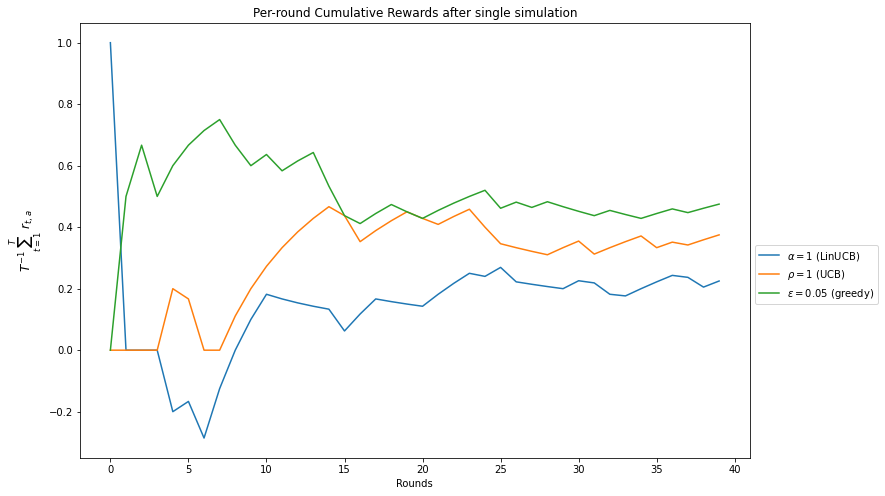

In [8]:
# compare algorithms

#===============================
#    Epsilon Greedy ...
#===============================
mab = EpsGreedy(5, 0.05)
results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 40)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

#===============================
#    UCB ...
#===============================
mab = UCB(5, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 40)
print('UCB average reward', np.mean(results_UCB))

#===============================
#    Linear UCB (Contextual) ...
#===============================
mab = LinUCB(5, 56, 1.0)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 40)
print('LinUCB average reward', np.mean(results_LinUCB))

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB/np.linspace(1,40,40), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_reward_UCB/(np.linspace(1,40,40)), label = r"$\rho=1$ (UCB)")
plt.plot(cumulative_reward_EpsGreedy/(np.linspace(1,40,40)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after single simulation")
plt.show()

In [9]:
# tuning - alpha에 정수 아닌 수를 넣으면 에러

# array of different alpha values ranging from 0 to 5 (excluding 0 itself because alpha is member of R+) with step of .01
alphas = np.linspace(0,5,501)[1:]
# average reward of LinUCB per each alpha value
average_results = np.zeros(len(alphas))

#===============================
#    Looping alphas ...
#===============================
for alpha in range(len(alphas)): 
    mab = LinUCB(5, 56, alphas[alpha])
    results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 50)
    average_results[alpha] = np.mean(results_LinUCB)
print('Best value of alpha resulting in maximum average reward is: ', alphas[np.argmax(average_results)])
#===============================
#    Plotting ...
#===============================
plt.figure(figsize=(12,8))
plt.plot(alphas, average_results, label = "$alpha=x.xx$ (LinUCB)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Alpha values")
plt.ylabel("Average Reward")
plt.title("Search strategy to optimize alpha value as hyper-parameter")
plt.show()

KeyboardInterrupt: 